In [180]:
import numpy as np
import pandas as pd
import random
import anndata as ad
from anndata import AnnData
import matplotlib.pyplot as plt
import matplotlib
import scanpy as sc
import squidpy as sq
import scipy 
from sklearn import cluster
from sklearn import neighbors
from collections.abc import Iterable, Mapping, Sequence

import seaborn as sns

from matplotlib.axes import Axes
from matplotlib.colors import Colormap, Normalize
from matplotlib.figure import Figure
from matplotlib.backends.backend_pdf import PdfPages

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

import warnings
warnings.filterwarnings("ignore")

In [181]:
def rank_genes_groups_violin_colorEdit(
    adata: AnnData,
    groups: Sequence[str] | None = None,
    *,
    palette = None,
    plot_max = None,
    n_genes: int = 20,
    gene_names: Iterable[str] | None = None,
    gene_symbols: str | None = None,
    use_raw: bool | None = None,
    key: str | None = None,
    split: bool = True,
    scale: str = "width",
    strip: bool = True,
    jitter: int | float | bool = True,
    size: int = 1,
    ax: Axes | None = None,
    show: bool | None = None,
    save: bool | None = None,
):
    """\
    Plot ranking of genes for all tested comparisons.

    Parameters
    ----------
    adata
        Annotated data matrix.
    groups
        List of group names.
    n_genes
        Number of genes to show. Is ignored if `gene_names` is passed.
    gene_names
        List of genes to plot. Is only useful if interested in a custom gene list,
        which is not the result of :func:`scanpy.tl.rank_genes_groups`.
    gene_symbols
        Key for field in `.var` that stores gene symbols if you do not want to
        use `.var_names` displayed in the plot.
    use_raw
        Use `raw` attribute of `adata` if present. Defaults to the value that
        was used in :func:`~scanpy.tl.rank_genes_groups`.
    split
        Whether to split the violins or not.
    scale
        See :func:`~seaborn.violinplot`.
    strip
        Show a strip plot on top of the violin plot.
    jitter
        If set to 0, no points are drawn. See :func:`~seaborn.stripplot`.
    size
        Size of the jitter points.
    {show_save_ax}
    """
    
    from scanpy.plotting._utils import (
    savefig_or_show,
    timeseries,
    timeseries_as_heatmap,
    timeseries_subplot,
    )
    
    from scanpy.get import obs_df
    
    from scanpy._settings import settings
    
    if key is None:
        key = "rank_genes_groups"
    groups_key = str(adata.uns[key]["params"]["groupby"])
    if use_raw is None:
        use_raw = bool(adata.uns[key]["params"]["use_raw"])
    reference = str(adata.uns[key]["params"]["reference"])
    groups_names = adata.uns[key]["names"].dtype.names if groups is None else groups
    if isinstance(groups_names, str):
        groups_names = [groups_names]
    axs = []
    for group_name in groups_names:
        if gene_names is None:
            _gene_names = adata.uns[key]["names"][group_name][:n_genes]
        else:
            _gene_names = gene_names
        if isinstance(_gene_names, np.ndarray):
            _gene_names = _gene_names.tolist()
        df = obs_df(adata, _gene_names, use_raw=use_raw, gene_symbols=gene_symbols)
        new_gene_names = df.columns
        df["hue"] = adata.obs[groups_key].astype(str).values
        if reference == "rest":
            df.loc[df["hue"] != group_name, "hue"] = "rest"
        else:
            df.loc[~df["hue"].isin([group_name, reference]), "hue"] = np.nan
        df["hue"] = df["hue"].astype("category")
        df_tidy = pd.melt(df, id_vars="hue", value_vars=new_gene_names)
        x = "variable"
        y = "value"
        hue_order = [group_name, reference]
        import seaborn as sns
        
        print(df_tidy)
        
        if plot_max == None:
            plot_max = np.max(df_tidy['value']) 

        _ax = sns.violinplot(
            x=x,
            y=y,
            data=df_tidy,
            inner=None,
            hue_order=hue_order,
            hue="hue",
            split=split,
            scale=scale,
            orient="vertical",
            ax=ax,
            palette = palette,
            )
        
        if strip:
            _ax = sns.stripplot(
                x=x,
                y=y,
                data=df_tidy,
                hue="hue",
                dodge=True,
                hue_order=hue_order,
                jitter=jitter,
                color="black",
                size=size,
                ax=_ax,
            )
        _ax.set_xlabel("genes")
        _ax.set_title(f"{group_name} vs. {reference}")
        _ax.legend_.remove()
        _ax.set_ylim(bottom=0, top=plot_max )
        _ax.set_ylabel("expression")
        _ax.set_xticklabels(new_gene_names, rotation="vertical")
        writekey = (
            f"rank_genes_groups_"
            f"{adata.uns[key]['params']['groupby']}_"
            f"{group_name}"
        )
        savefig_or_show(writekey, show=show, save=save)
        axs.append(_ax)
    show = settings.autoshow if show is None else show
    if show:
        return None
    return axs

In [182]:
#####
###When loading in the tissue_positions file, it reads from the 2nd (i.e. line 1) in the original code, and not from line 0 like it should

from __future__ import annotations

import json
import os
import re
from pathlib import Path
from typing import (
    Any,
    Union,  # noqa: F401
)

import numpy as np
import pandas as pd
from anndata import AnnData
from scanpy import logging as logg
from scipy.sparse import csr_matrix

from squidpy._constants._pkg_constants import Key
from squidpy.datasets._utils import PathLike
from squidpy.read._utils import _load_image, _read_counts

__all__ = ["visium", "vizgen", "nanostring"]


def visium(
    path: PathLike,
    *,
    counts_file: str = "filtered_feature_bc_matrix.h5",
    library_id: str | None = None,
    load_images: bool = True,
    source_image_path: PathLike | None = None,
    **kwargs: Any,
) -> AnnData:
    """
    Read *10x Genomics* Visium formatted dataset.

    In addition to reading the regular *Visium* output, it looks for the *spatial* directory and loads the images,
    spatial coordinates and scale factors.

    .. seealso::

        - `Space Ranger output <https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview>`_.
        - :func:`squidpy.pl.spatial_scatter` on how to plot spatial data.

    Parameters
    ----------
    path
        Path to the root directory containing *Visium* files.
    counts_file
        Which file in the passed directory to use as the count file. Typically either *filtered_feature_bc_matrix.h5* or
        *raw_feature_bc_matrix.h5*.
    library_id
        Identifier for the *Visium* library. Useful when concatenating multiple :class:`anndata.AnnData` objects.
    kwargs
        Keyword arguments for :func:`scanpy.read_10x_h5`, :func:`anndata.read_mtx` or :func:`read_text`.

    Returns
    -------
    Annotated data object with the following keys:

        - :attr:`anndata.AnnData.obsm` ``['spatial']`` - spatial spot coordinates.
        - :attr:`anndata.AnnData.uns` ``['spatial']['{library_id}']['images']`` - *hires* and *lowres* images.
        - :attr:`anndata.AnnData.uns` ``['spatial']['{library_id}']['scalefactors']`` - scale factors for the spots.
        - :attr:`anndata.AnnData.uns` ``['spatial']['{library_id}']['metadata']`` - various metadata.
    """  # noqa: E501
    path = Path(path)
    adata, library_id = _read_counts(path, count_file=counts_file, library_id=library_id, **kwargs)

    if not load_images:
        return adata

    adata.uns[Key.uns.spatial][library_id][Key.uns.image_key] = {
        res: _load_image(path / f"{Key.uns.spatial}/tissue_{res}_image.png") for res in ["hires", "lowres"]
    }
    adata.uns[Key.uns.spatial][library_id]["scalefactors"] = json.loads(
        (path / f"{Key.uns.spatial}/scalefactors_json.json").read_bytes()
    )

    tissue_positions_file = (
        path / "spatial/tissue_positions.csv"
        if (path / "spatial/tissue_positions.csv").exists()
        else path / "spatial/tissue_positions_list.csv"
    )

    coords = pd.read_csv(
        tissue_positions_file,
        header=0 if tissue_positions_file.name == "tissue_positions.csv" else None,
        index_col=0,
    )
    coords.columns = ["in_tissue", "array_row", "array_col", "pxl_col_in_fullres", "pxl_row_in_fullres"]
    # https://github.com/scverse/squidpy/issues/657
    coords.set_index(coords.index.astype(adata.obs.index.dtype), inplace=True)

    adata.obs = pd.merge(adata.obs, coords, how="left", left_index=True, right_index=True)
    adata.obsm[Key.obsm.spatial] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values
    adata.obs.drop(columns=["pxl_row_in_fullres", "pxl_col_in_fullres"], inplace=True)

    if source_image_path is not None:
        source_image_path = Path(source_image_path).absolute()
        if not source_image_path.exists():
            logg.warning(f"Path to the high-resolution tissue image `{source_image_path}` does not exist")
        adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(source_image_path)

    return adata

In [184]:

#Make font size bigger and standardise fig size
matplotlib.rcParams.update({'font.size': 15})
default_rc_params = matplotlib.rcParams['figure.figsize']
matplotlib.rcParams['figure.figsize'] = default_rc_params

In [185]:
#Load in data
day7_visium = visium("/datastore3/RossOlympia/Day7_seperatePackageTest/outs", counts_file="filtered_feature_bc_matrix.h5", library_id = "Day7")
day7_visium.obs["total_counts"] = np.sum(day7_visium.X, axis = 1)
day7_visium.var_names_make_unique()

#Load in location IDs
location_id = pd.read_csv("/datastore3/RossOlympia/Day7_seperatePackageTest/MyAnnotationsWithBlanks_v7.csv", index_col = 0)
day7_visium.obs["location"] = location_id
day7_visium.obs["spot_id"] =  day7_visium.obs.index

basement_id = pd.read_csv("/datastore3/RossOlympia/Day7_seperatePackageTest/basement_upper.csv", index_col = 0)
day7_visium.obs["basement_layer"] = basement_id
# sq.pl.spatial_scatter(day7_visium, color = "basement_layer")

basement_id = pd.read_csv("/datastore3/RossOlympia/Day7_seperatePackageTest/centre.csv", index_col = 0)
day7_visium.obs["centre"] = basement_id
# sq.pl.spatial_scatter(day7_visium, color = "centre")

day7_visium.obs['sample'] = "day7_PI"

day7_visium.obs['location'] = day7_visium.obs['location'].replace({np.nan:"unlabelled"})

day7_visium.obs['location']=day7_visium.obs['location'].astype('str').astype('category')

day7_visium.obs['location']= day7_visium.obs['location'].cat.rename_categories(['Crypts', 'Granuloma', 'Villi', 'Worm', 'unlabelled'])

day7_visium.obs['location_sample'] = day7_visium.obs["location"].astype("string")  + "_" + day7_visium.obs["sample"].astype("string")

day7_visium = day7_visium[day7_visium.obs['location'] != "unlabelled"].copy()




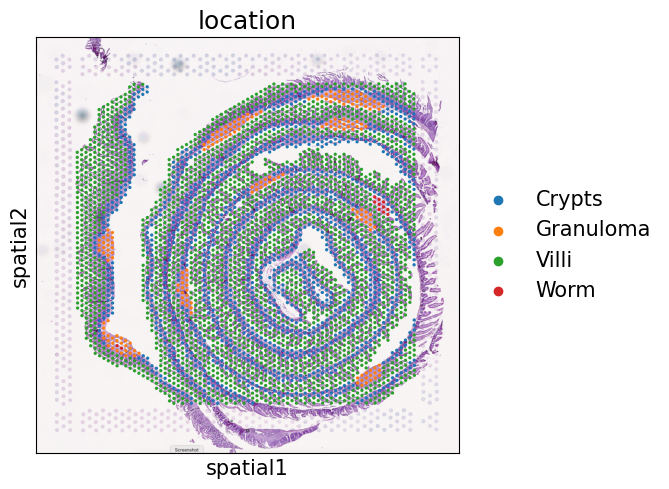

In [186]:
sq.pl.spatial_scatter(day7_visium, color = "location")

In [187]:
naive1_visium = visium("/datastore3/RossOlympia/Naive_1/Naive1/outs", counts_file="filtered_feature_bc_matrix.h5", library_id = "Day7")
naive1_visium.obs["total_counts"] = np.sum(naive1_visium.X, axis = 1)
naive1_visium.var_names_make_unique()

#Load in location IDs
location_id = pd.read_csv("/datastore3/RossOlympia/Naive_1/myannotationNaive1All_V5.csv", index_col = 0)
naive1_visium.obs["location"] = location_id
naive1_visium.obs["spot_id"] =  naive1_visium.obs.index

basement_id = pd.read_csv("/datastore3/RossOlympia/Naive_1/naive1_basement_layer.csv", index_col = 0)
naive1_visium.obs["basement_layer"] = basement_id
# sq.pl.spatial_scatter(day7_visium, color = "basement_layer")

basement_id = pd.read_csv("/datastore3/RossOlympia/Naive_1/centre_Naive1.csv", index_col = 0)
naive1_visium.obs["centre"] = basement_id
# sq.pl.spatial_scatter(day7_visium, color = "centre")

naive1_visium.obs['location'] = naive1_visium.obs['location'].replace({np.nan:"unlabelled"})

naive1_visium.obs['location']=naive1_visium.obs['location'].astype('str').astype('category')

naive1_visium.obs['location']= naive1_visium.obs['location'].cat.rename_categories(['Crypts', 'Villi', 'unlabelled'])

naive1_visium.obs['sample'] = "naive"

naive1_visium.obs['basement_layer'] = naive1_visium.obs['basement_layer'].replace({np.nan:"unlabelled"})

naive1_visium.obs['basement_layer']=naive1_visium.obs['basement_layer'].astype('str').astype('category')

naive1_visium.obs['basement_layer']= naive1_visium.obs['basement_layer'].cat.rename_categories(['basement', 'unlabelled', 'upper'])

naive1_visium.obs['location_sample'] = naive1_visium.obs["location"].astype("string") + "_" + naive1_visium.obs["sample"].astype("string")

naive1_visium = naive1_visium[naive1_visium.obs['location'] != "unlabelled"].copy()

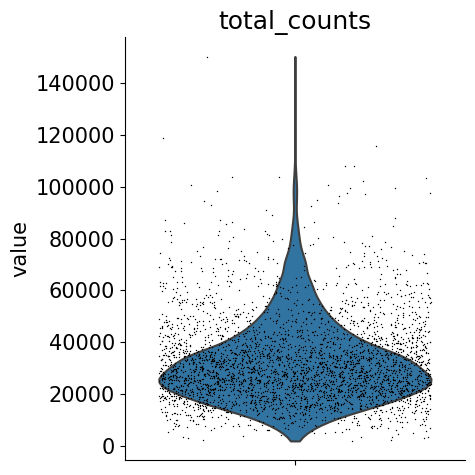

1841.0

In [188]:
sc.pl.violin(naive1_visium, ['total_counts'],
             jitter=0.4, multi_panel=True)

np.min(naive1_visium.obs['total_counts'])

In [189]:
# Process visium

visium_list = [day7_visium, naive1_visium]

pc_list=[13, 17]

for i in range(len(visium_list)):
    current_visium = visium_list[i].copy()
    
    sc.pp.filter_genes(current_visium, min_cells=3)
    
    current_visium.layers['raw'] = current_visium.X.copy()
    
    sc.pp.normalize_total(current_visium, target_sum=1e4)
    sc.pp.log1p(current_visium)
    
    current_visium.raw = current_visium
    
    visium_list[i] = current_visium.copy()

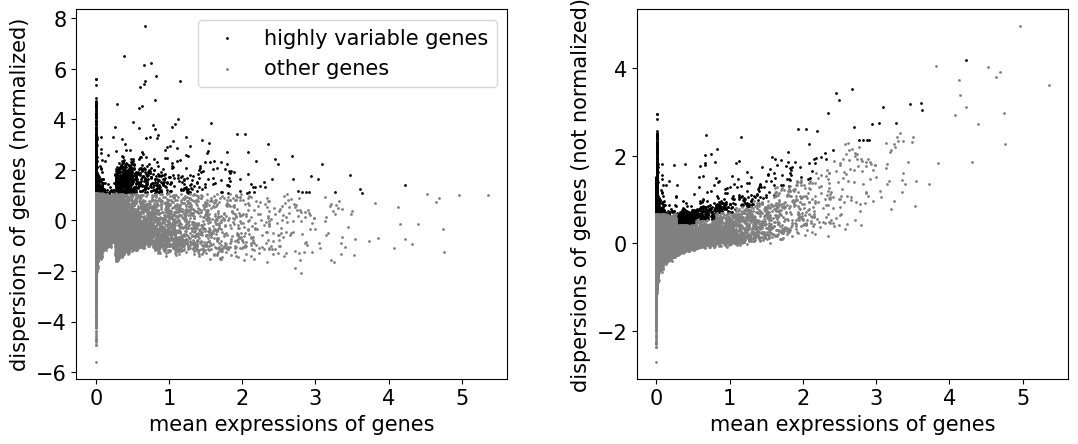

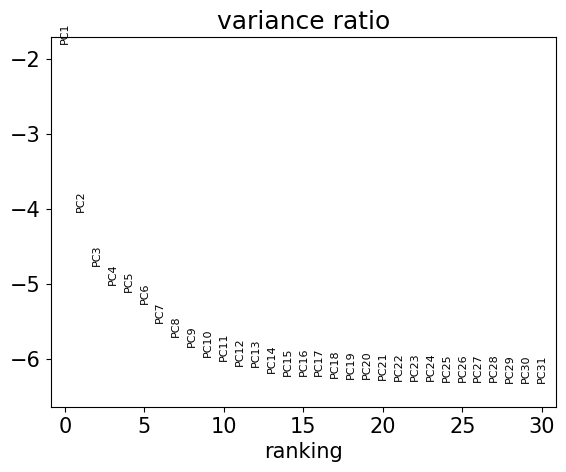

2024-02-08 13:41:22,519 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-02-08 13:41:25,707 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-02-08 13:41:25,729 - harmonypy - INFO - Iteration 1 of 10
2024-02-08 13:41:26,809 - harmonypy - INFO - Iteration 2 of 10
2024-02-08 13:41:27,891 - harmonypy - INFO - Converged after 2 iterations


In [191]:
#integrate harmony
visium_list = [day7_visium, naive1_visium]

var_names = visium_list[0].var_names.intersection(visium_list[1].var_names)
visium_list[0] = visium_list[0][:, var_names]
visium_list[1] = visium_list[1][:, var_names]

adata_concat = visium_list[0].concatenate(visium_list[1], batch_categories=['day7', 'naive'])

adata_concat.layers['raw'] = adata_concat.X.copy()

sc.pp.normalize_total(adata_concat, target_sum=1e4)
sc.pp.log1p(adata_concat)

sc.pp.highly_variable_genes(adata_concat, n_top_genes=2000)
sc.pl.highly_variable_genes(adata_concat)

adata_concat.raw = adata_concat
    
# adata_concat = adata_concat[:, adata_concat.var.highly_variable]

sc.pp.regress_out(adata_concat, ['total_counts'])

sc.pp.scale(adata_concat, max_value=10)

sc.tl.pca(adata_concat, svd_solver='arpack',use_highly_variable = True)

sc.pl.pca_variance_ratio(adata_concat, log=True)

sc.external.pp.harmony_integrate(adata_concat, 'batch')

In [192]:

sc.pp.neighbors(adata_concat, n_pcs=16, use_rep="X_pca_harmony")

sc.tl.umap(adata_concat)

sc.tl.leiden(adata_concat,resolution=0.3, key_added = "transcriptome_cluster")
    

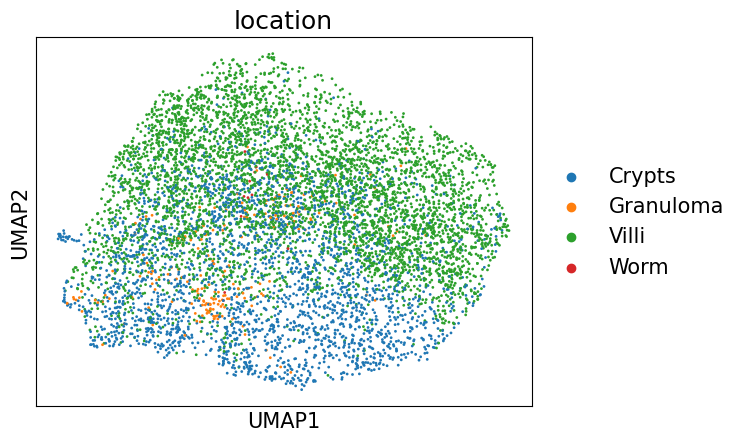

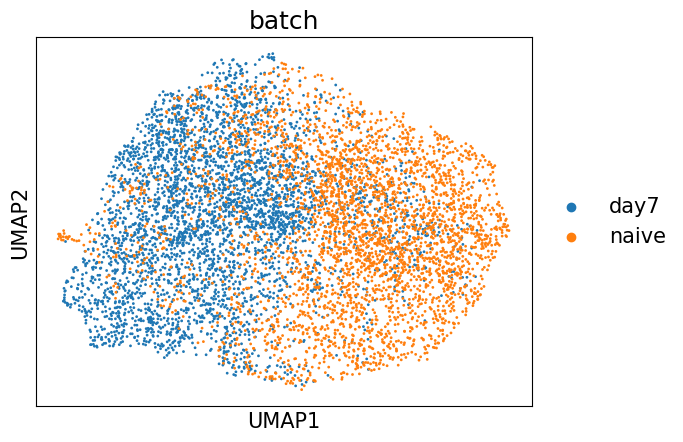

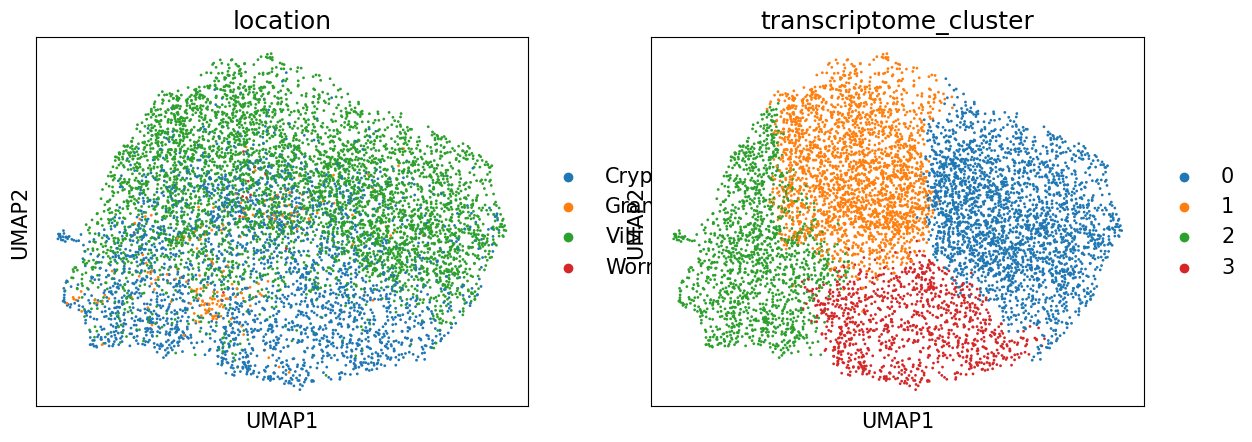

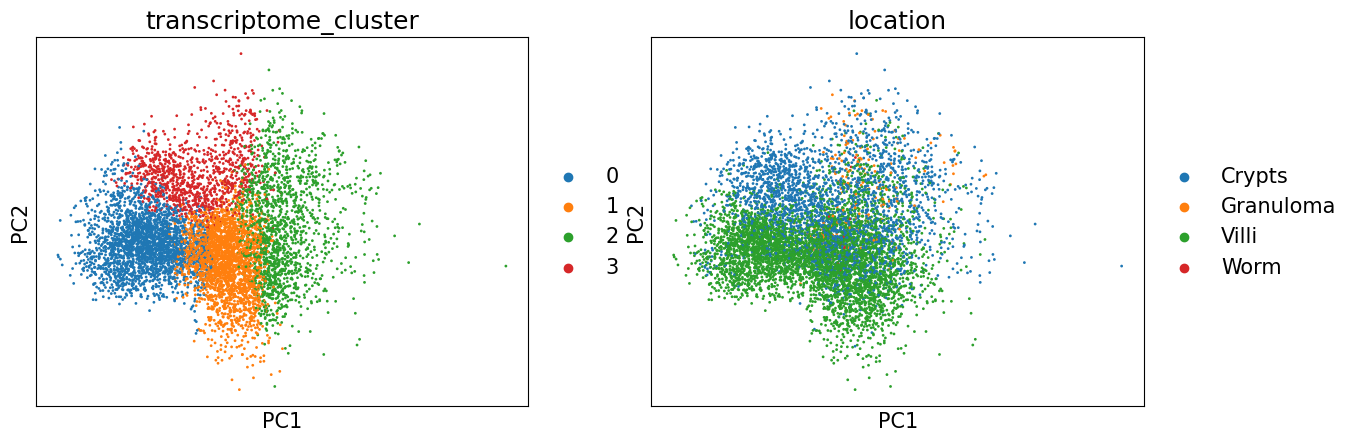

In [195]:
sc.pl.umap(adata_concat, color = ['location'])
sc.pl.umap(adata_concat, color = ['batch'])

sc.pl.umap(adata_concat, color = ['location', 'transcriptome_cluster'])
sc.pl.pca(adata_concat, color = ['transcriptome_cluster', 'location'])

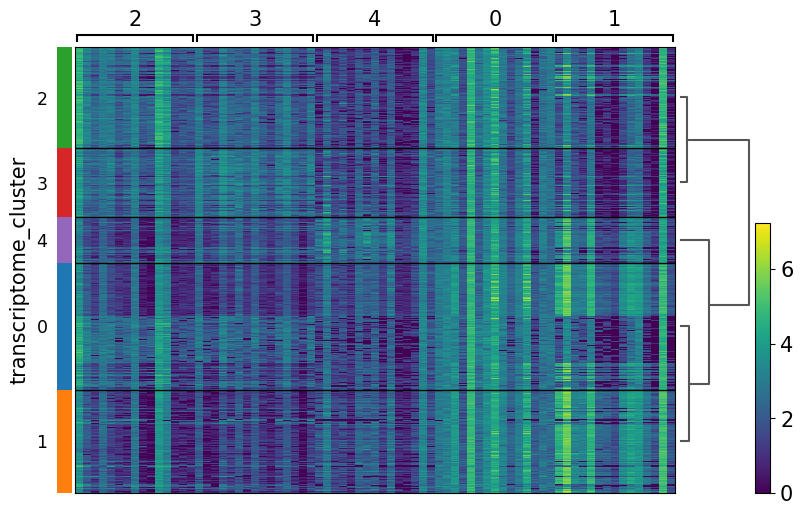

In [172]:
#Plots to generate

sc.tl.rank_genes_groups(adata_concat, 'transcriptome_cluster', method='t-test', use_raw=True)
sc.tl.filter_rank_genes_groups(adata_concat)

sc.pl.rank_genes_groups_heatmap(adata_concat, n_genes= 15)
# sc.pl.rank_genes_groups_heatmap(adata_concat, n_genes= 15, layers = "counts")


#Volcano plot of crypt day7 vs crypt naive and the same for villi

In [174]:
#We are only comapring the villi and crypt, so we will remove the granuloma and worm

adata_concat = adata_concat[adata_concat.obs.location.isin(["Villi", "Crypts"])].copy()


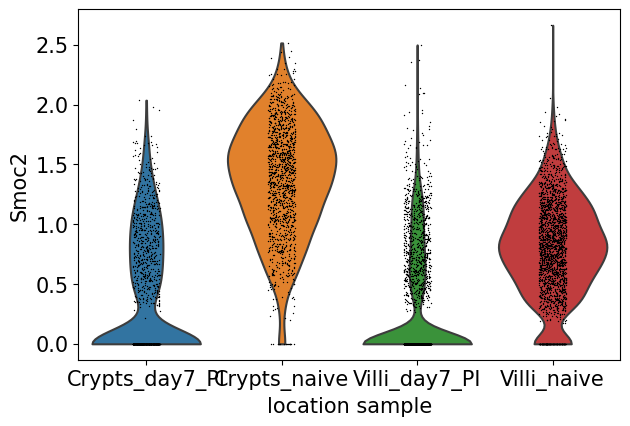

In [175]:
sc.pl.violin(adata_concat, keys = "Smoc2", groupby = "location_sample")

                  hue variable     value
0      Crypts_day7_PI    Epcam  2.762336
1                 NaN    Epcam  2.344701
2                 NaN    Epcam  2.144459
3                 NaN    Epcam  2.699428
4                 NaN    Epcam  2.827754
...               ...      ...       ...
73065    Crypts_naive    Itln1  4.413085
73066    Crypts_naive    Itln1  3.725012
73067             NaN    Itln1  3.330959
73068             NaN    Itln1  2.947901
73069             NaN    Itln1  2.342975

[73070 rows x 3 columns]


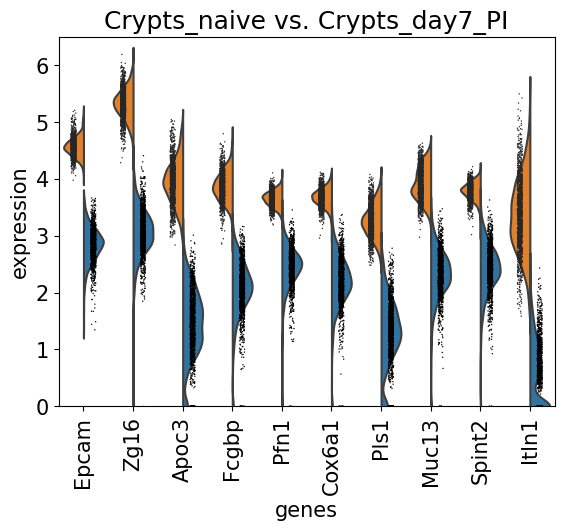

categories: Crypts_day7_PI, Crypts_naive, Villi_day7_PI, etc.
var_group_labels: Crypts_naive


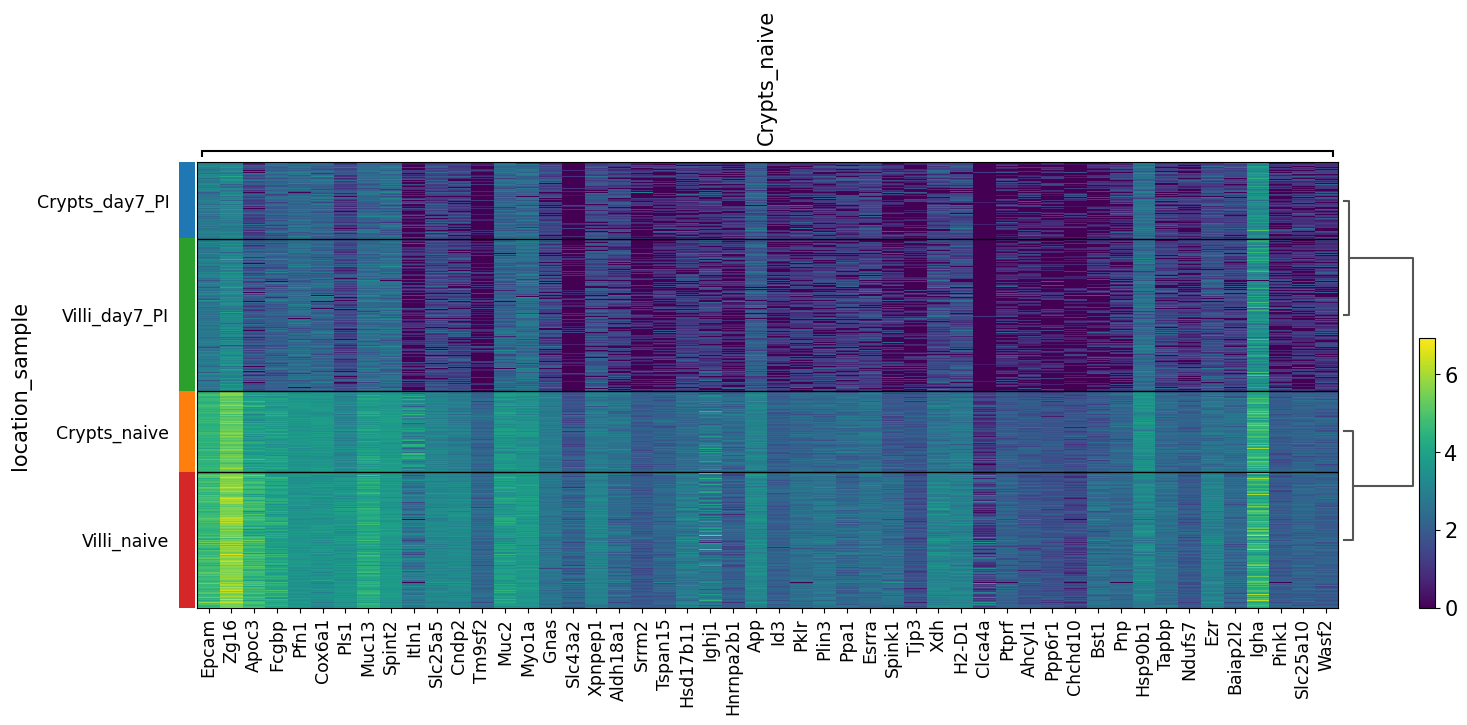

In [176]:
#compare crypt naive vs crypt day 7

sc.tl.rank_genes_groups(adata_concat, 'location_sample', groups=['Crypts_naive'], reference='Crypts_day7_PI', method='wilcoxon')
rank_genes_groups_violin_colorEdit(adata_concat, groups='Crypts_naive', n_genes=10, strip = True, palette = ['#ff7f0e','#1f77b4'], plot_max = 6.5)

sc.pl.rank_genes_groups_heatmap(adata_concat, n_genes= 50, groups=["Crypts_naive"])



                  hue variable     value
0      Crypts_day7_PI    Cldn3  5.267231
1                 NaN    Cldn3  5.683608
2                 NaN    Cldn3  5.249716
3                 NaN    Cldn3  5.206651
4                 NaN    Cldn3  5.249354
...               ...      ...       ...
73065    Crypts_naive   Rab5if  1.727302
73066    Crypts_naive   Rab5if  2.201741
73067             NaN   Rab5if  1.719007
73068             NaN   Rab5if  1.784947
73069             NaN   Rab5if  1.271712

[73070 rows x 3 columns]


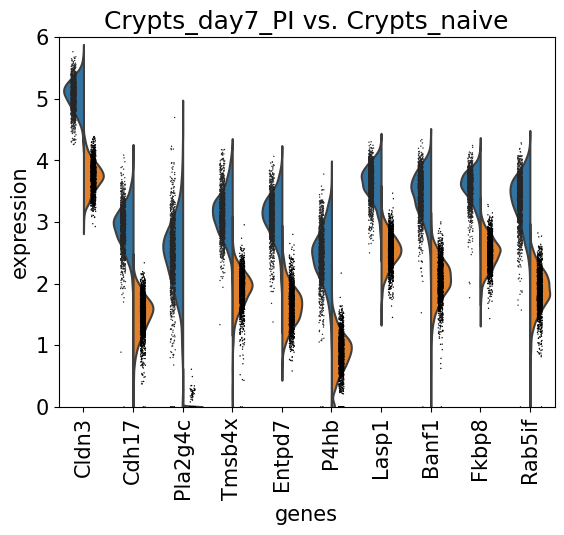

categories: Crypts_day7_PI, Crypts_naive, Villi_day7_PI, etc.
var_group_labels: Crypts_day7_PI


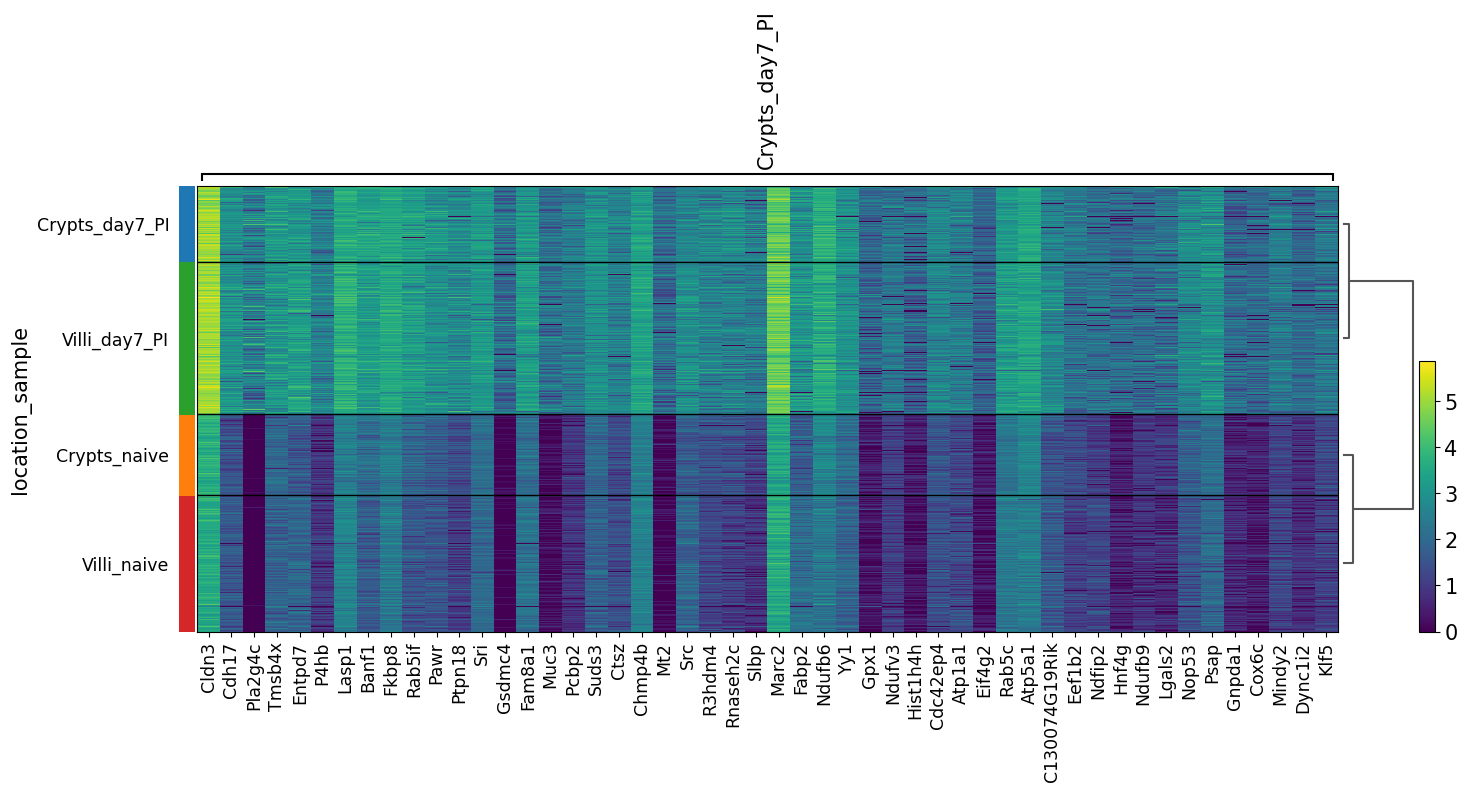

In [177]:
sc.tl.rank_genes_groups(adata_concat, 'location_sample', groups=['Crypts_day7_PI'], reference='Crypts_naive', method='wilcoxon')
rank_genes_groups_violin_colorEdit(adata_concat, groups='Crypts_day7_PI', n_genes=10, strip = True, palette = ['#1f77b4','#ff7f0e'], plot_max = 6)
sc.pl.rank_genes_groups_heatmap(adata_concat, n_genes= 50, groups=["Crypts_day7_PI"])


                 hue variable     value
0                NaN    Cldn3  5.267231
1      Villi_day7_PI    Cldn3  5.683608
2      Villi_day7_PI    Cldn3  5.249716
3      Villi_day7_PI    Cldn3  5.206651
4      Villi_day7_PI    Cldn3  5.249354
...              ...      ...       ...
73065            NaN    Lasp1  2.026999
73066            NaN    Lasp1  2.773175
73067    Villi_naive    Lasp1  3.061101
73068    Villi_naive    Lasp1  2.966310
73069    Villi_naive    Lasp1  2.848240

[73070 rows x 3 columns]


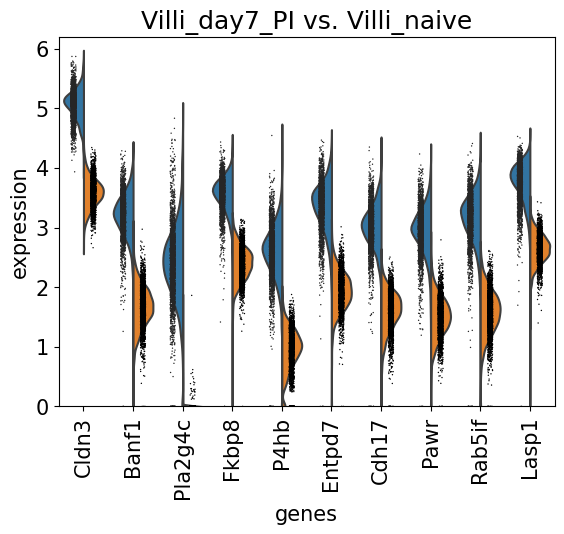

categories: Crypts_day7_PI, Crypts_naive, Villi_day7_PI, etc.
var_group_labels: Villi_day7_PI


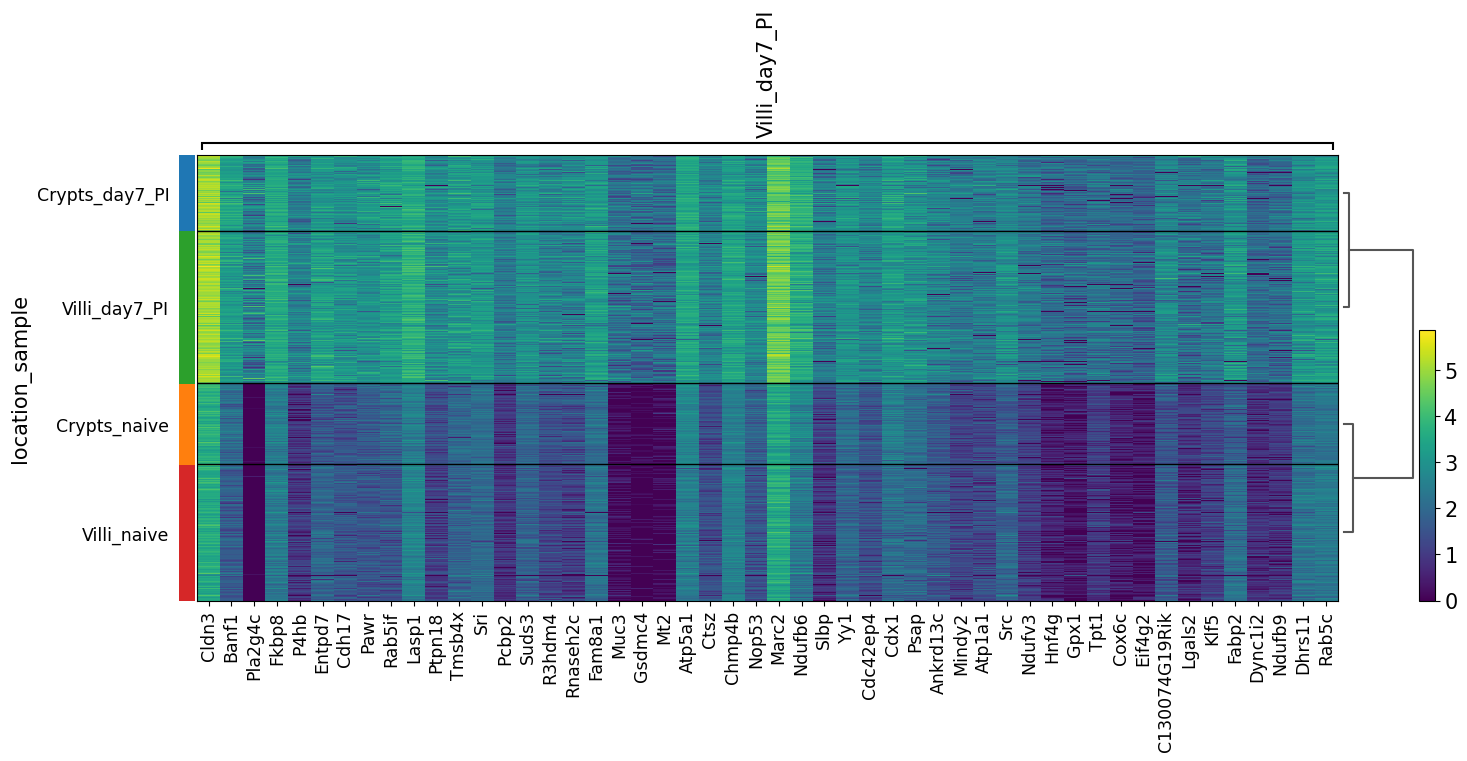

In [178]:
#compare villi day 7 vs villi naive
sc.tl.rank_genes_groups(adata_concat, 'location_sample', groups=['Villi_day7_PI'], reference='Villi_naive', method='wilcoxon')
rank_genes_groups_violin_colorEdit(adata_concat, groups='Villi_day7_PI', n_genes=10, strip = True, palette = ['#1f77b4','#ff7f0e'], plot_max = 6.2)


sc.pl.rank_genes_groups_heatmap(adata_concat, n_genes= 50, groups=["Villi_day7_PI"])




                 hue variable     value
0                NaN    Epcam  2.762336
1      Villi_day7_PI    Epcam  2.344701
2      Villi_day7_PI    Epcam  2.144459
3      Villi_day7_PI    Epcam  2.699428
4      Villi_day7_PI    Epcam  2.827754
...              ...      ...       ...
73065            NaN     Pfn1  3.561851
73066            NaN     Pfn1  3.744215
73067    Villi_naive     Pfn1  3.641281
73068    Villi_naive     Pfn1  3.714263
73069    Villi_naive     Pfn1  3.749483

[73070 rows x 3 columns]


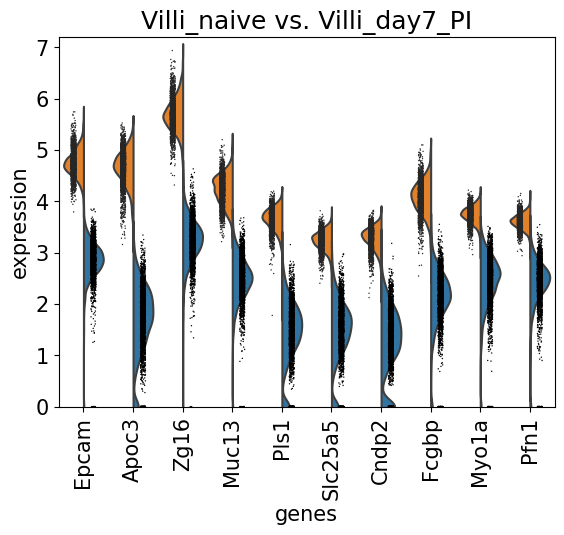

categories: Crypts_day7_PI, Crypts_naive, Villi_day7_PI, etc.
var_group_labels: Villi_naive


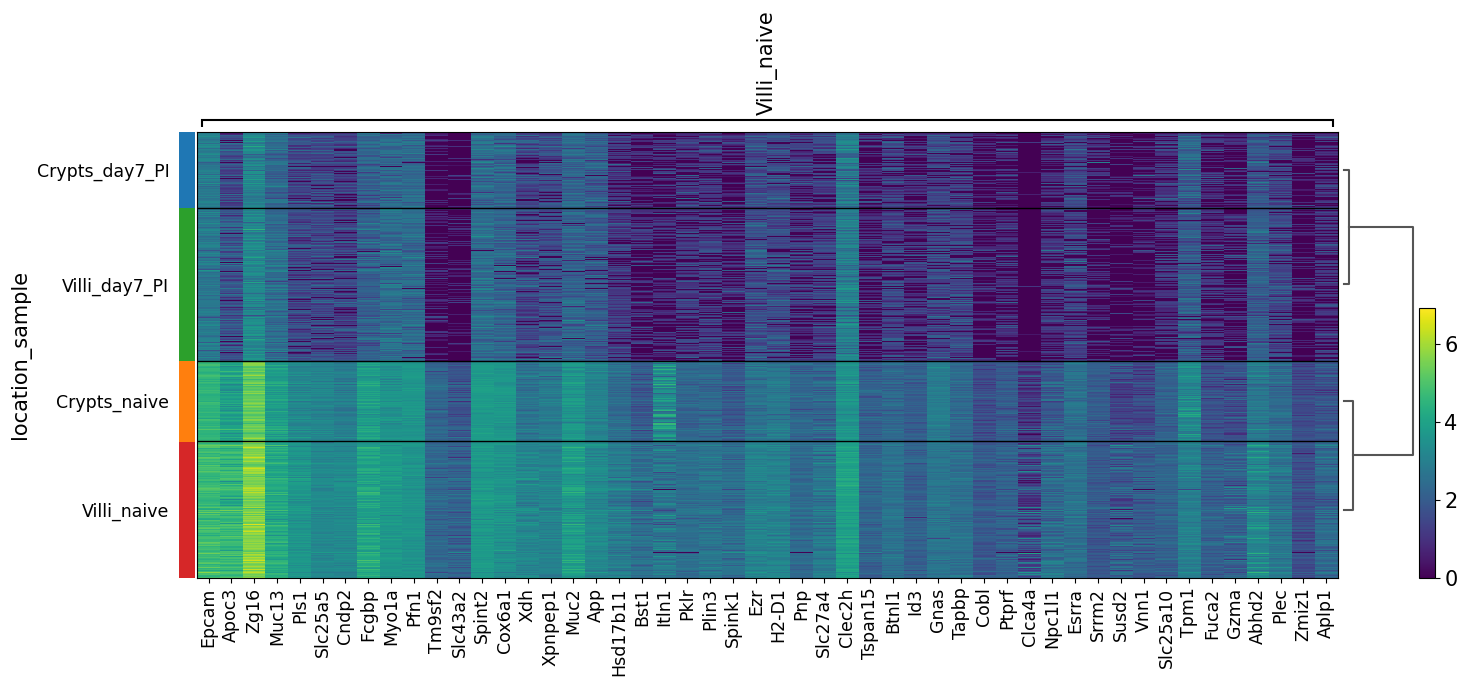

In [179]:
#compare villi naive vs villi day 7

sc.tl.rank_genes_groups(adata_concat, 'location_sample', groups=['Villi_naive'], reference='Villi_day7_PI', method='wilcoxon')
rank_genes_groups_violin_colorEdit(adata_concat, groups='Villi_naive', n_genes=10, strip = True, palette = ['#ff7f0e','#1f77b4'], plot_max = 7.2)

sc.pl.rank_genes_groups_heatmap(adata_concat, n_genes= 50, groups=["Villi_naive"])
